# Code for figures of "Decomposing the Drivers of Polar Amplification with a Single Column Model" by Matthew Henry, Tim Merlis, Nicholas Lutsko, and Brian Rose

# Setup an "issue" or email matthew.henry@mail.mcgill.ca for questions

# Preliminary imports and functions

In [1]:
%load_ext autoreload
%autoreload 2
%precision 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from utils_un import ncdf_obj
import matplotlib.cm as cm
import ClimateUtils as clim
import climlab
import netCDF4
from netCDF4 import Dataset
from scipy import interpolate

def mean_lat(lat,val):
    
    if(lat.shape[0] != val.shape[0]):
        print("Latitude and value vectors not of same size.")
        return 0
    else :
        # assume lat in degrees
        w = np.cos(lat*np.pi/180)
        return np.sum(val*w)/np.sum(w)

def plot_pole(field_lin, lat, lat_lev):

    lr_lin=np.zeros((field_lin).shape[0],)

    for i in range(field_lin.shape[0]):
        lr_lin[i]=mean_lat(lat[lat>lat_lev],field_lin[i,lat>lat_lev])

    return lr_lin

def plot_eq(field_lin, lat, lat_lev):

    lr_lin=np.zeros((field_lin).shape[0],)
    masks = [lat>-lat_lev,lat<lat_lev]
    mask = masks[0] & masks[1]

    for i in range(field_lin.shape[0]):
        lr_lin[i]=mean_lat(lat[mask],field_lin[i,mask])

    return lr_lin

class ExternalForcing(climlab.process.TimeDependentProcess):
    def __init__(self,**kwargs):
        super(ExternalForcing, self).__init__(**kwargs)
        self.forcing_tendencies = {}
        for var in self.state:
            self.forcing_tendencies[var] = 0. * self.state[var]

    def _compute(self):
        return self.forcing_tendencies

co2 = ncdf_obj('/home/mhenry/Research_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm')
co2_HS12 = ncdf_obj('/home/mhenry/Research_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm_HS12')
co2_HS24 = ncdf_obj('/home/mhenry/Research_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm_HS24')

nonlin = ncdf_obj('/home/mhenry/Research_data/','idealised_moist_AM2rad_albedo/300ppm','idealised_moist_AM2rad_albedo_fixedsst/1200ppm')
forcing_CO2 = np.mean(np.mean(nonlin.s_lin_14xCO2.variables['swdn_toa'][:],0),1)-np.mean(np.mean(nonlin.s_lin.variables['swdn_toa'][:],0),1)\
         -np.mean(np.mean(nonlin.s_lin_14xCO2.variables['swup_toa'][:],0),1)+np.mean(np.mean(nonlin.s_lin.variables['swup_toa'][:],0),1)+\
    np.mean(np.mean(nonlin.s_lin.variables['olr'][:],0),1)-np.mean(np.mean(nonlin.s_lin_14xCO2.variables['olr'][:],0),1)

# Set up standard column models in high latitudes and tropics

In [2]:
def run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True, transpQ_ctl=True, 
                    sh_ctl=True, surf_forc=0, q_spec=0, lat=80):
    
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)
    model = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_advection'][:],0),2)
    dt_adv_ctl = iGCM_run.plot_pole(dt_adv_ctl_,lat)
    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)
    dt_adv_inc = iGCM_run.plot_pole(dt_adv_inc_,lat)
    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_condensation'][:],0),2)
    dt_cond_ctl = iGCM_run.plot_pole(dt_cond_ctl_,lat)
    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)
    dt_cond_inc = iGCM_run.plot_pole(dt_cond_inc_,lat)

    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    if(sh_ctl==True):
        sh = np.interp(model.lev,iGCM_run.sig_*1000,iGCM_run.plot_pole(iGCM_run.q_lin,lat))
    else:
        sh = np.interp(model.lev,iGCM_run.sig_*1000,iGCM_run.plot_pole(iGCM_run.q_lin_14xCO2,lat))
    if(isinstance(q_spec,np.ndarray)):
        sh = q_spec
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=sh,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transpT_ctl==True and transpQ_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit
    elif transpT_ctl==False and transpQ_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit
    elif transpT_ctl==True and transpQ_ctl == False:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit_inc
    elif transpT_ctl==False and transpQ_ctl == False:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit_inc
    myforcing.forcing_tendencies['Ts']=surf_forc
    shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
    lhf.q = sh
    model.add_subprocess('Radiation', rad)
    # model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('SHF', shf)
    model.add_subprocess('LHF', lhf)
    model.integrate_years(3,False)
    return model

def run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True, q_spec = 0, 
                  lat=10):
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5., lat=10)
    model_t = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_advection'][:],0),2)*3600*24
    dt_adv_ctl = plot_eq(dt_adv_ctl_,iGCM_run.lat_,lat)
    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl)/(24*3600))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit_t = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]

    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)*3600*24
    dt_adv_inc = plot_eq(dt_adv_inc_,iGCM_run.lat_,lat)
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc)/(24*3600))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc_t = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_condensation'][:],0),2)*3600*24
    dt_cond_ctl = plot_eq(dt_cond_ctl_,iGCM_run.lat_,lat)
    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl)/(24*3600))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit_t = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]

    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)*3600*24
    dt_cond_inc = plot_eq(dt_cond_inc_,iGCM_run.lat_,lat)
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc)/(24*3600))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc_t = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model_t.Tatm)
    abs_vmr['CO2']=co2_lev
    if(sh_ctl == True):
        sh = np.interp(model_t.lev,iGCM_run.sig_*1000,plot_eq(iGCM_run.q_lin,iGCM_run.lat_,lat))
    else:
        sh = np.interp(model_t.lev,iGCM_run.sig_*1000,plot_eq(iGCM_run.q_lin_14xCO2,iGCM_run.lat_,lat))
    if(isinstance(q_spec,np.ndarray)):
        sh = q_spec
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=sh,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transp_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_t+dt_cond_fit_t
    else:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc_t+dt_cond_fit_inc_t
    shf = climlab.surface.SensibleHeatFlux(state=model_t.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model_t.state, Cd=0.5E-3)
    lhf.q = sh
    model_t.add_subprocess('Radiation', rad)
    model_t.add_subprocess('ConvectiveAdjustment', conv)
    model_t.add_subprocess('advective forcing', myforcing)
    model_t.add_subprocess('SHF', shf)
    model_t.add_subprocess('LHF', lhf)
    model_t.integrate_years(3,False)
    return model_t

# Define run_eq_column and run_pole_column for fixed RH experiments

In [3]:
def run_pole_column_fixedRH(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True, 
                            transpQ_ctl=True, surf_forc=0, q_spec=0, lat=80,RH_ctl=True):
    
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)
    model = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_advection'][:],0),2)
    dt_adv_ctl = iGCM_run.plot_pole(dt_adv_ctl_,lat)
    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)
    dt_adv_inc = iGCM_run.plot_pole(dt_adv_inc_,lat)
    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_condensation'][:],0),2)
    dt_cond_ctl = iGCM_run.plot_pole(dt_cond_ctl_,lat)
    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)
    dt_cond_inc = iGCM_run.plot_pole(dt_cond_inc_,lat)

    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
    if(RH_ctl == True):
        h2o.RH_profile = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(
            iGCM_run.f_lin.variables['rhum_avg'][:],iGCM_run.lat_,lat))
    else:
        h2o.RH_profile = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(
            iGCM_run.f_lin_14xCO2.variables['rhum_avg'][:],iGCM_run.lat_,lat))
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=h2o.q,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transpT_ctl==True and transpQ_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit
    elif transpT_ctl==False and transpQ_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit
    elif transpT_ctl==True and transpQ_ctl == False:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit_inc
    elif transpT_ctl==False and transpQ_ctl == False:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit_inc
    myforcing.forcing_tendencies['Ts']=surf_forc
    shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
    lhf.q = h2o.q
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('WaterVapor', h2o)
    model.add_subprocess('SHF', shf)
    model.add_subprocess('LHF', lhf)
    model.integrate_years(3,False)
    return model

def run_eq_column_fixedRH(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True, q_spec = 0, 
                  lat=10,RH_ctl=True):
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5., lat=10)
    model = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_advection'][:],0),2)*3600*24
    dt_adv_ctl = plot_eq(dt_adv_ctl_,iGCM_run.lat_,lat)
    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl)/(24*3600))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit_t = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]

    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)*3600*24
    dt_adv_inc = plot_eq(dt_adv_inc_,iGCM_run.lat_,lat)
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc)/(24*3600))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc_t = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_condensation'][:],0),2)*3600*24
    dt_cond_ctl = plot_eq(dt_cond_ctl_,iGCM_run.lat_,lat)
    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl)/(24*3600))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit_t = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]

    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)*3600*24
    dt_cond_inc = plot_eq(dt_cond_inc_,iGCM_run.lat_,lat)
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc)/(24*3600))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc_t = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
    if(RH_ctl == True):
        h2o.RH_profile = np.interp(model.lev,iGCM_run.sig_*1000,plot_eq(
            iGCM_run.f_lin.variables['rhum_avg'][:],iGCM_run.lat_,lat))
    else:
        h2o.RH_profile = np.interp(model.lev,iGCM_run.sig_*1000,plot_eq(
            iGCM_run.f_lin_14xCO2.variables['rhum_avg'][:],iGCM_run.lat_,lat))
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=h2o.q,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transp_ctl == True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_t+dt_cond_fit_t
    else:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc_t+dt_cond_fit_inc_t
    shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
    lhf.q = h2o.q
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('WaterVapor', h2o)
    model.add_subprocess('SHF', shf)
    model.add_subprocess('LHF', lhf)
    model.integrate_years(3,False)
    return model

# Run fixed RH column models for high latitudes (p) and tropics (t)

In [4]:
model_p_ctl_RH = run_pole_column_fixedRH(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, 
                                    transpT_ctl=True,transpQ_ctl=True, lat=80)
model_p_co2_RH = run_pole_column_fixedRH(iGCM_run=co2, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                    transpT_ctl=True,transpQ_ctl=True, lat=80)
model_p_full_RH = run_pole_column_fixedRH(iGCM_run=co2, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                     transpT_ctl=False,transpQ_ctl=False, lat=80)
model_p_co2_RH_HS12 = run_pole_column_fixedRH(iGCM_run=co2_HS12, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                    transpT_ctl=True,transpQ_ctl=True, lat=80, surf_forc=4e-7)
model_p_full_RH_HS12 = run_pole_column_fixedRH(iGCM_run=co2_HS12, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                     transpT_ctl=False,transpQ_ctl=False, lat=80, surf_forc=4e-7)
model_p_co2_RH_HS24 = run_pole_column_fixedRH(iGCM_run=co2_HS24, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                    transpT_ctl=True,transpQ_ctl=True,lat=80, surf_forc=8e-7)
model_p_full_RH_HS24 = run_pole_column_fixedRH(iGCM_run=co2_HS24, co2_lev=12e-4, insol=175.2, alb=0.54, 
                                     transpT_ctl=False,transpQ_ctl=False,lat=80, surf_forc=8e-7)
model_t_ctl_RH = run_eq_column_fixedRH(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, 
                                   lat=10)
model_t_co2_RH = run_eq_column_fixedRH(iGCM_run=co2, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, 
                                   lat=10)
model_t_full_RH = run_eq_column_fixedRH(iGCM_run=co2, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, 
                                    lat=10)
model_t_co2_RH_HS12 = run_eq_column_fixedRH(iGCM_run=co2_HS12, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, 
                                   lat=10)
model_t_full_RH_HS12 = run_eq_column_fixedRH(iGCM_run=co2_HS12, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, 
                                    lat=10)
model_t_co2_RH_HS24 = run_eq_column_fixedRH(iGCM_run=co2_HS24, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, 
                                   lat=10)
model_t_full_RH_HS24 = run_eq_column_fixedRH(iGCM_run=co2_HS24, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, 
                                    lat=10)

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2

# Plot Figure 1 (Surface temperature changes for idealized GCM and CMIP6)

In [35]:
class ts_obj:
    
    def __init__(self, fil):
        self.pic = netCDF4.Dataset(fil)
        self.lat = self.pic.variables['lat'][:]
        self.ts_diff = np.nanmean(self.pic.variables['ts'],0)
        self.ts_diff_pattern = self.ts_diff/mean_lat(self.lat,self.ts_diff)

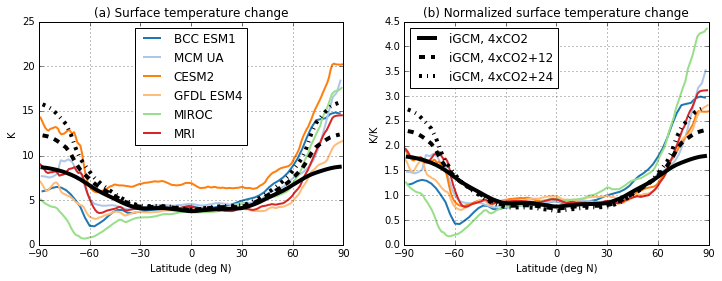

In [37]:
#setup tableau 10 colors
tableau = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
(188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau)):    
    r, g, b = tableau[i]    
    tableau[i] = (r / 255., g / 255., b / 255.)

BCCESM1 = ts_obj('./cmip6_data/ts_diff_BCC-ESM1.nc')
# CanESM5 = ts_obj('./cmip6_data/ts_diff_CanESM5.nc')
CESM2 = ts_obj('./cmip6_data/ts_diff_CESM2.nc')
GFDL = ts_obj('./cmip6_data/ts_diff_GFDL-ESM4.nc')
MCM_UA = ts_obj('./cmip6_data/ts_diff_MCM-UA-1-0.nc')
# GISSE2 = ts_obj('./cmip6_data/ts_diff_GISS-E2-1-H.nc')
# IPSL_CM6A = ts_obj('./cmip6_data/ts_diff_IPSL-CM6A-LR.nc')
MIROC = ts_obj('./cmip6_data/ts_diff_MIROC6.nc')
MRI = ts_obj('./cmip6_data/ts_diff_MRI-ESM2-0.nc')
# NESM3 = ts_obj('./cmip6_data/ts_diff_NESM3.nc')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(BCCESM1.lat,BCCESM1.ts_diff, c=tableau[0], linewidth=2, label='BCC ESM1')
plt.plot(MCM_UA.lat,MCM_UA.ts_diff, c=tableau[1], linewidth=2, label='MCM UA')
plt.plot(CESM2.lat,CESM2.ts_diff, c=tableau[2], linewidth=2, label='CESM2')
plt.plot(GFDL.lat,GFDL.ts_diff, c=tableau[3], linewidth=2, label='GFDL ESM4')
plt.plot(MIROC.lat,MIROC.ts_diff, c=tableau[5], linewidth=2, label='MIROC')
plt.plot(MRI.lat,MRI.ts_diff, c=tableau[6], linewidth=2, label='MRI')
plt.plot(co2.lat_,co2.sat_lin_diff, 'k', linewidth=4)
plt.plot(co2.lat_,co2_HS12.sat_lin_diff, 'k--', linewidth=4)
plt.plot(co2.lat_,co2_HS24.sat_lin_diff,'k-.', linewidth=4)
plt.grid()
plt.title('(a) Surface temperature change')
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
# plt.ylim([-0.5,2.5])
lgd = plt.legend(loc='best')
plt.ylabel('K')
plt.xlabel('Latitude (deg N)')

plt.subplot(1,2,2)
plt.plot(BCCESM1.lat,BCCESM1.ts_diff_pattern, c=tableau[0], linewidth=2)
plt.plot(MCM_UA.lat,MCM_UA.ts_diff_pattern, c=tableau[1], linewidth=2)
plt.plot(CESM2.lat,CESM2.ts_diff_pattern, c=tableau[2], linewidth=2)
plt.plot(GFDL.lat,GFDL.ts_diff_pattern, c=tableau[3], linewidth=2)
plt.plot(MIROC.lat,MIROC.ts_diff_pattern, c=tableau[5], linewidth=2)
plt.plot(MRI.lat,MRI.ts_diff_pattern, c=tableau[6], linewidth=2)
plt.plot(co2.lat_,co2.sat_lin_diff/mean_lat(co2.lat_,co2.sat_lin_diff), 'k', linewidth=4, label='iGCM, 4xCO2')
plt.plot(co2.lat_,co2_HS12.sat_lin_diff/mean_lat(co2.lat_,co2_HS12.sat_lin_diff), 'k--', linewidth=4, label='iGCM, 4xCO2+12')
plt.plot(co2.lat_,co2_HS24.sat_lin_diff/mean_lat(co2.lat_,co2_HS24.sat_lin_diff),'k-.', label='iGCM, 4xCO2+24', linewidth=4)
plt.grid()
plt.title('(b) Normalized surface temperature change')
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
# plt.ylim([-0.5,2.5])
# lgd = plt.legend(bbox_to_anchor=(1.54, 1.025))
lgd = plt.legend(loc='best')
plt.ylabel('K/K')
plt.xlabel('Latitude (deg N)')

plt.savefig('fig1.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Plot Figure 2 (SCM and idealized GCM comparison)

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
175.199661792
83.3128156181
175.117007982
84.2110828441
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
414.999220764
57.3219953829
414.467290768
83.76922588


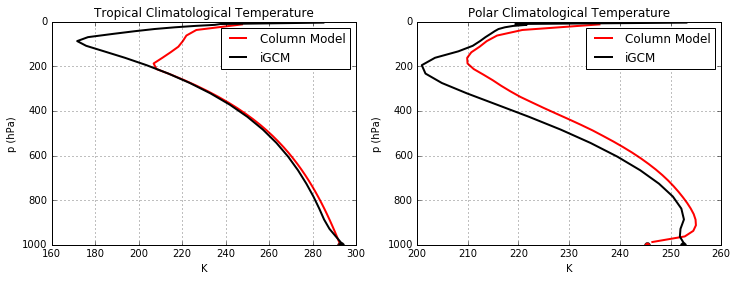

In [7]:
iGCM_run=co2
model = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=True)

TOA_SW_down = model.SW_flux_down[0]
print(TOA_SW_down)
TOA_SW_up = model.SW_flux_up[0]
print(TOA_SW_up)

swsfc_net = np.mean(np.mean(iGCM_run.s_lin.variables['swsfc'][:],0),1)
swtoa_up = np.mean(np.mean(iGCM_run.s_lin.variables['swup_toa'][:],0),1)
swtoa_dn = np.mean(np.mean(iGCM_run.s_lin.variables['swdn_toa'][:],0),1)

print(mean_lat(iGCM_run.lat_[iGCM_run.lat_>=80],swtoa_dn[iGCM_run.lat_>=80]))
print(mean_lat(iGCM_run.lat_[iGCM_run.lat_>=80],swtoa_up[iGCM_run.lat_>=80]))

model_t = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True,sh_ctl=True)

TOA_SW_down = model_t.SW_flux_down[0]
print(TOA_SW_down)
TOA_SW_up = model_t.SW_flux_up[0]
print(TOA_SW_up)

swsfc_net = np.mean(np.mean(iGCM_run.s_lin.variables['swsfc'][:],0),1)
swtoa_up = np.mean(np.mean(iGCM_run.s_lin.variables['swup_toa'][:],0),1)
swtoa_dn = np.mean(np.mean(iGCM_run.s_lin.variables['swdn_toa'][:],0),1)

masks = [iGCM_run.lat_>-10,iGCM_run.lat_<10]
mask = masks[0] & masks[1]
print(mean_lat(iGCM_run.lat_[mask],swtoa_dn[mask]))
print(mean_lat(iGCM_run.lat_[mask],swtoa_up[mask]))

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t.state['Tatm'],model_t.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_eq(iGCM_run.temp_lin),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[mask],iGCM_run.sat_lin[mask]), 1000, 'ko',markersize=6)
plt.title('Tropical Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model.state['Tatm'],model.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_pole(iGCM_run.temp_lin,80),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[iGCM_run.lat_>80],iGCM_run.sat_lin[iGCM_run.lat_>80]), 1000, 'ko',markersize=6)
plt.title('Polar Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('fig2.eps', bbox_inches='tight')
plt.show()

# Run all (perturbed) single column models (poles and then tropics)

In [8]:
lat_p = 80
model = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True, transpQ_ctl=True, sh_ctl=True, surf_forc=0)

model_co2 = run_pole_column(iGCM_run=co2, co2_lev=12e-4, insol=175.2, alb=0.54, transpT_ctl=False, transpQ_ctl=False, sh_ctl=False, surf_forc=0)
model_co2_co2 = run_pole_column(iGCM_run=co2, co2_lev=12e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=True, surf_forc=0)
model_co2_transT = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=False,transpQ_ctl=True, sh_ctl=True, surf_forc=0)
model_co2_transQ = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=False, sh_ctl=True, surf_forc=0)
model_co2_q = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54,transpT_ctl=True,transpQ_ctl=True, sh_ctl=False, surf_forc=0)
model_co2_q_local = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54,transpT_ctl=True,
                    transpQ_ctl=True, sh_ctl=True, surf_forc=0,q_spec = np.interp(model.lev,iGCM_run.sig_*1000,iGCM_run.plot_pole(co2.q_lin,lat_p))+(model_p_co2_RH.q-model_p_ctl_RH.q))
model_co2_q_remote_Tatm = model_co2_q.Tatm-(model_co2_q_local.Tatm-model.Tatm)
model_co2_q_remote_Ts = model_co2_q.Ts-(model_co2_q_local.Ts-model.Ts)

model_HS12_co2_all = run_pole_column(iGCM_run=co2_HS12, co2_lev=12e-4, insol=175.2, alb=0.54, transpT_ctl=False,transpQ_ctl=False, sh_ctl=False, surf_forc=4e-7)
model_HS12_co2 = run_pole_column(iGCM_run=co2_HS12, co2_lev=12e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=True, surf_forc=0)
model_HS12_transT = run_pole_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=False,transpQ_ctl=True, sh_ctl=True, surf_forc=0)
model_HS12_transQ = run_pole_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=False, sh_ctl=True, surf_forc=0)
model_HS12_q = run_pole_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=False, surf_forc=0)
model_HS12_q_local = run_pole_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=175.2, alb=0.54,transpT_ctl=True,
                              transpQ_ctl=True, sh_ctl=True, surf_forc=0,q_spec = np.interp(model.lev,iGCM_run.sig_*1000,iGCM_run.plot_pole(co2.q_lin,lat_p))+(model_p_co2_RH_HS12.q-model_p_ctl_RH.q))
model_HS12_surf = run_pole_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=True, surf_forc=4e-7)
model_HS12_q_remote_Tatm = model_HS12_q.Tatm-(model_HS12_q_local.Tatm-model.Tatm)
model_HS12_q_remote_Ts = model_HS12_q.Ts-(model_HS12_q_local.Ts-model.Ts)

model_HS24_co2_all = run_pole_column(iGCM_run=co2_HS24, co2_lev=12e-4, insol=175.2, alb=0.54, transpT_ctl=False,transpQ_ctl=False, sh_ctl=False, surf_forc=8e-7)
model_HS24_transT = run_pole_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=False,transpQ_ctl=True, sh_ctl=True, surf_forc=0)
model_HS24_transQ = run_pole_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=False, sh_ctl=True, surf_forc=0)
model_HS24_q = run_pole_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=False, surf_forc=0)
model_HS24_q_local = run_pole_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=175.2, alb=0.54,transpT_ctl=True,
                              transpQ_ctl=True, sh_ctl=True, surf_forc=0,q_spec = np.interp(model.lev,iGCM_run.sig_*1000,iGCM_run.plot_pole(co2.q_lin,lat_p))+(model_p_co2_RH_HS24.q-model_p_ctl_RH.q))
model_HS24_surf = run_pole_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=175.2, alb=0.54, transpT_ctl=True,transpQ_ctl=True, sh_ctl=True, surf_forc=8e-7)
model_HS24_q_remote_Tatm = model_HS24_q.Tatm-(model_HS24_q_local.Tatm-model.Tatm)
model_HS24_q_remote_Ts = model_HS24_q.Ts-(model_HS24_q_local.Ts-model.Ts)

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2

In [9]:
lat_t = 10
model_t = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True)
model_t_co2 = run_eq_column(iGCM_run=co2, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=False)
model_t_co2_co2 = run_eq_column(iGCM_run=co2, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True)
model_t_co2_trans = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=True)
model_t_co2_q = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False)
model_t_co2_q_local = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False,
                                   q_spec =  np.interp(model.lev,iGCM_run.sig_*1000,plot_eq(co2.q_lin,iGCM_run.lat_,lat_t))+(model_t_co2_RH.q-model_t_ctl_RH.q))
model_t_co2_q_remote_Tatm = model_t_co2_q.Tatm-(model_t_co2_q_local.Tatm-model_t.Tatm)
model_t_co2_q_remote_Ts = model_t_co2_q.Ts-(model_t_co2_q_local.Ts-model_t.Ts)

model_t_HS12 = run_eq_column(iGCM_run=co2_HS12, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=False)
model_t_HS12_co2 = run_eq_column(iGCM_run=co2_HS12, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True)
model_t_HS12_trans = run_eq_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=True)
model_t_HS12_q = run_eq_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False)
model_t_HS12_q_local = run_eq_column(iGCM_run=co2_HS12, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False,
                                   q_spec =  np.interp(model.lev,iGCM_run.sig_*1000,plot_eq(co2_HS12.q_lin,iGCM_run.lat_,lat_t))+(model_t_co2_RH_HS12.q-model_t_ctl_RH.q))
model_t_HS12_q_remote_Tatm = model_t_HS12_q.Tatm-(model_t_HS12_q_local.Tatm-model_t.Tatm)
model_t_HS12_q_remote_Ts = model_t_HS12_q.Ts-(model_t_HS12_q_local.Ts-model_t.Ts)

model_t_HS24 = run_eq_column(iGCM_run=co2_HS24, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=False)
model_t_HS24_co2 = run_eq_column(iGCM_run=co2_HS24, co2_lev=12e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=True)
model_t_HS24_trans = run_eq_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=False, sh_ctl=True)
model_t_HS24_q = run_eq_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False)
model_t_HS24_q_local = run_eq_column(iGCM_run=co2_HS24, co2_lev=3e-4, insol=415, alb=0.07, transp_ctl=True, sh_ctl=False,
                                   q_spec =  np.interp(model.lev,iGCM_run.sig_*1000,plot_eq(co2_HS24.q_lin,iGCM_run.lat_,lat_t))+(model_t_co2_RH_HS24.q-model_t_ctl_RH.q))
model_t_HS24_q_remote_Tatm = model_t_HS24_q.Tatm-(model_t_HS24_q_local.Tatm-model_t.Tatm)
model_t_HS24_q_remote_Ts = model_t_HS24_q.Ts-(model_t_HS24_q_local.Ts-model_t.Ts)

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2

# Plot figure 3 (SCM lapse rate changes)

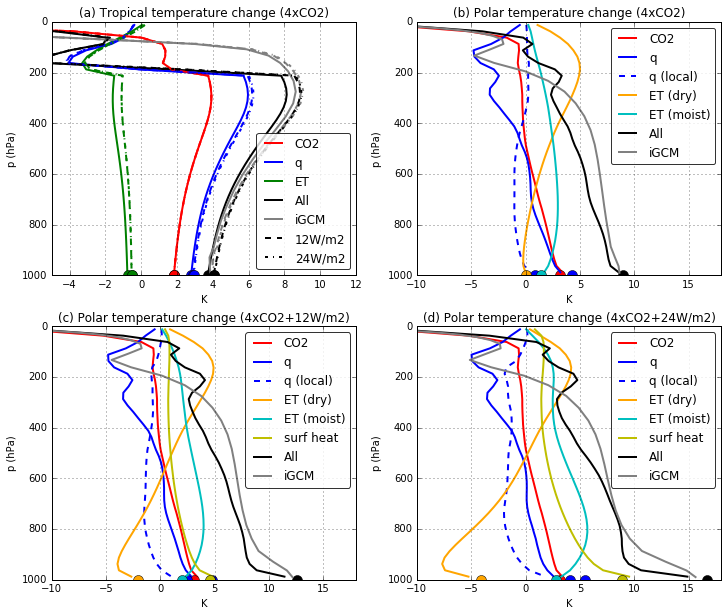

In [10]:
msize=10

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,10)
plt.subplot(2,2,1)
plt.plot(model_t_co2_co2.state['Tatm'] - model_t.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_t_co2_co2.state['Ts'] - model_t.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_co2_q_local.state['Tatm'] + model_t_co2_q_remote_Tatm - 2*model_t.state['Tatm'],model.lev,c='b',label='q',linewidth=2)
plt.plot(model_t_co2_q_local.state['Ts'] + model_t_co2_q_remote_Ts - 2*model_t.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_co2_trans.state['Tatm'] - model_t.state['Tatm'],model.lev,c='g',label='ET',linewidth=2)
plt.plot(model_t_co2_trans.state['Ts'] - model_t.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_co2.state['Tatm'] - model_t.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_t_co2.state['Ts'] - model_t.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(co2.plot_eq(co2.temp_lin_diff),co2.sig_*1000, 'grey', label='iGCM',linewidth=2)

plt.plot(model_t_HS12_co2.state['Tatm'] - model_t.state['Tatm'],model.lev,'--r',linewidth=2)
plt.plot(model_t_HS12_co2.state['Ts'] - model_t.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_co2_q_local.state['Tatm'] + model_t_HS12_q_remote_Tatm - 2*model_t.state['Tatm'],model.lev,'--b',linewidth=2)
plt.plot(model_t_co2_q_local.state['Ts'] + model_t_HS12_q_remote_Ts - 2*model_t.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_HS12_trans.state['Tatm'] - model_t.state['Tatm'],model.lev,'g', linestyle='--',linewidth=2)
plt.plot(model_t_HS12_trans.state['Ts'] - model_t.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_HS12.state['Tatm'] - model_t.state['Tatm'],model.lev,'k--',linewidth=2, label='12W/m2')
plt.plot(model_t_HS12.state['Ts'] - model_t.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(co2.plot_eq(co2_HS12.temp_lin_diff),co2.sig_*1000, 'grey', linestyle='--',linewidth=2)

plt.plot(model_t_HS24_co2.state['Tatm'] - model_t.state['Tatm'],model.lev,'r-.',linewidth=2)
plt.plot(model_t_HS24_co2.state['Ts'] - model_t.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_co2_q_local.state['Tatm'] + model_t_HS24_q_remote_Tatm - 2*model_t.state['Tatm'],model.lev,'b-.',linewidth=2)
plt.plot(model_t_co2_q_local.state['Ts'] + model_t_HS24_q_remote_Ts - 2*model_t.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_HS24_trans.state['Tatm'] - model_t.state['Tatm'],model.lev,c='g', linestyle='-.',linewidth=2)
plt.plot(model_t_HS24_trans.state['Ts'] - model_t.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_HS24.state['Tatm'] - model_t.state['Tatm'],model.lev,'k-.',linewidth=2, label='24W/m2')
plt.plot(model_t_HS24.state['Ts'] - model_t.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(co2.plot_eq(co2_HS24.temp_lin_diff),co2.sig_*1000, 'grey', linestyle='-.',linewidth=2)

plt.title('(a) Tropical temperature change (4xCO2)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-5,12])
lgd =plt.legend(loc='best',fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(2,2,2)
plt.plot(model_co2_co2.state['Tatm'] - model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_co2_co2.state['Ts'] - model.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_co2_q_local.state['Tatm'] + model_co2_q_remote_Tatm - 2*model.state['Tatm'],model.lev,c='b',label='q',linewidth=2)
plt.plot(model_co2_q_local.state['Ts'] + model_co2_q_remote_Ts - 2*model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_co2_q_local.state['Tatm'] - model.state['Tatm'],model.lev,'b--',label='q (local)',linewidth=2)
plt.plot(model_co2_q_local.state['Ts'] - model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_co2_transT.state['Tatm'] - model.state['Tatm'],model.lev,c='orange',label='ET (dry)',linewidth=2)
plt.plot(model_co2_transT.state['Ts'] - model.state['Ts'], 1000, marker='o', c='orange',markersize=msize)
plt.plot(model_co2_transQ.state['Tatm'] - model.state['Tatm'],model.lev,c='c',label='ET (moist)',linewidth=2)
plt.plot(model_co2_transQ.state['Ts'] - model.state['Ts'], 1000, 'co',markersize=msize)
plt.plot(model_co2.state['Tatm'] - model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_co2.state['Ts'] - model.state['Ts'],1000, 'ko',markersize=msize)
plt.plot(co2.plot_pole(co2.temp_lin_diff,80),co2.sig_*1000, 'grey', label='iGCM',linewidth=2)
plt.title('(b) Polar temperature change (4xCO2)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-10,18])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(2,2,3)
plt.plot(model_HS12_co2.state['Tatm'] - model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_HS12_co2.state['Ts'] - model.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_HS12_q_local.state['Tatm'] + model_HS12_q_remote_Tatm - 2*model.state['Tatm'],model.lev,c='b',label='q',linewidth=2)
plt.plot(model_HS12_q_local.state['Ts'] + model_HS12_q_remote_Ts - 2*model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_HS12_q_local.state['Tatm']- model.state['Tatm'],model.lev,'b--',label='q (local)',linewidth=2)
plt.plot(model_HS12_q_local.state['Ts'] - model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_HS12_transT.state['Tatm'] - model.state['Tatm'],model.lev,c='orange',label='ET (dry)',linewidth=2)
plt.plot(model_HS12_transT.state['Ts'] - model.state['Ts'], 1000,marker='o', c='orange',markersize=msize)
plt.plot(model_HS12_transQ.state['Tatm'] - model.state['Tatm'],model.lev,c='c',label='ET (moist)',linewidth=2)
plt.plot(model_HS12_transQ.state['Ts'] - model.state['Ts'], 1000, 'co',markersize=msize)
plt.plot(model_HS12_surf.state['Tatm'] - model.state['Tatm'],model.lev,c='y',label='surf heat',linewidth=2)
plt.plot(model_HS12_surf.state['Ts'] - model.state['Ts'], 1000, 'yo',markersize=msize)
plt.plot(model_HS12_co2_all.state['Tatm'] - model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_HS12_co2_all.state['Ts'] - model.state['Ts'],1000, 'ko',markersize=msize)
plt.plot(co2.plot_pole(co2_HS12.temp_lin_diff,80),co2.sig_*1000, 'grey', label='iGCM',linewidth=2)
plt.title('(c) Polar temperature change (4xCO2+12W/m2)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-10,18])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()


plt.subplot(2,2,4)
plt.plot(model_co2_co2.state['Tatm'] - model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_co2_co2.state['Ts'] - model.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_HS24_q_local.state['Tatm'] + model_HS24_q_remote_Tatm - 2*model.state['Tatm'],model.lev,c='b',label='q',linewidth=2)
plt.plot(model_HS24_q_local.state['Ts'] + model_HS24_q_remote_Ts - 2*model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_HS24_q_local.state['Tatm'] - model.state['Tatm'],model.lev,'b--',label='q (local)',linewidth=2)
plt.plot(model_HS24_q_local.state['Ts'] - model.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_HS24_transT.state['Tatm'] - model.state['Tatm'],model.lev,c='orange',label='ET (dry)',linewidth=2)
plt.plot(model_HS24_transT.state['Ts'] - model.state['Ts'], 1000,marker='o', c='orange',markersize=msize)
plt.plot(model_HS24_transQ.state['Tatm'] - model.state['Tatm'],model.lev,c='c',label='ET (moist)',linewidth=2)
plt.plot(model_HS24_transQ.state['Ts'] - model.state['Ts'], 1000, 'co',markersize=msize)
plt.plot(model_HS24_surf.state['Tatm'] - model.state['Tatm'],model.lev,c='y',label='surf heat',linewidth=2)
plt.plot(model_HS24_surf.state['Ts'] - model.state['Ts'], 1000, 'yo',markersize=msize)
plt.plot(model_HS24_co2_all.state['Tatm'] - model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_HS24_co2_all.state['Ts'] - model.state['Ts'],1000, 'ko',markersize=msize)
plt.plot(co2.plot_pole(co2_HS24.temp_lin_diff,80),co2.sig_*1000, 'grey', label='iGCM',linewidth=2)
plt.title('(d) Polar temperature change (4xCO2+24W/m2)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-10,18])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.savefig('fig3.eps', bbox_inches='tight')
plt.show()

## Data for tables

In [11]:
%precision 2

print('tropics, 4xco2')
print('co2 : ',model_t_co2_co2.state['Ts'] - model_t.state['Ts'])
print('q: ',model_t_co2_q_remote_Ts +model_t_co2_q_local.state['Ts'] - 2*model_t.state['Ts'])
print('ET : ', model_t_co2_trans.state['Ts'] - model_t.state['Ts'])
print('all', model_t_co2.state['Ts'] - model_t.state['Ts'])
print()
print('tropics, 4xCO2+12W/m2')
print('CO2 : ', model_t_HS12_co2.state['Ts'] - model_t.state['Ts'])
print('q : ', model_t_HS12_q_remote_Ts + model_t_co2_q_local.state['Ts'] - 2*model_t.state['Ts'])
print('ET : ', model_t_HS12_trans.state['Ts'] - model_t.state['Ts'])
print('all : ', model_t_HS12.state['Ts'] - model_t.state['Ts'])
print()
print('tropics, 4xCO2+24W/m2')
print('CO2 : ', model_t_HS12_co2.state['Ts'] - model_t.state['Ts'])
print('q : ', model_t_co2_q_local.state['Ts'] + model_t_HS24_q_remote_Ts - 2*model_t.state['Ts'])
print('ET : ', model_t_HS24_trans.state['Ts'] - model_t.state['Ts'])
print('all : ', model_t_HS24.state['Ts'] - model_t.state['Ts'])
print()
print()
print('poles, 4xCO2')
print('co2 : ', model_co2_co2.state['Ts'] - model.state['Ts'])
print('q: ', model_co2_q_local.state['Ts'] + model_co2_q_remote_Ts - 2*model.state['Ts'])
print('ET (dry) : ', model_co2_transT.state['Ts'] - model.state['Ts'])
print('ET (moist) : ', model_co2_transQ.state['Ts'] - model.state['Ts'])
print('all : ', model_co2.state['Ts'] - model.state['Ts'])
print()
print('poles, 4xCO2+12W/m2')
print('co2 : ', model_HS12_co2.state['Ts'] - model.state['Ts'])
print('q : ', model_HS12_q_local.state['Ts'] + model_HS12_q_remote_Ts - 2*model.state['Ts'])
print('ET (dry): ',model_HS12_transT.state['Ts'] - model.state['Ts'])
print('ET (moist): ',model_HS12_transQ.state['Ts'] - model.state['Ts'])
print('SHS : ', model_HS12_surf.state['Ts'] - model.state['Ts'])
print('all : ', model_HS12_co2_all.state['Ts'] - model.state['Ts'])
print()
print('poles, 4xCO2+24W/m2')
print('co2 : ', model_co2_co2.state['Ts'] - model.state['Ts'])
print('q : ', model_HS24_q_remote_Ts + model_HS24_q_local.state['Ts'] - 2*model.state['Ts'])
print('ET (dry): ',model_HS24_transT.state['Ts'] - model.state['Ts'])
print('ET (moist): ',model_HS24_transQ.state['Ts'] - model.state['Ts'])
print('SHS : ', model_HS24_surf.state['Ts'] - model.state['Ts'])
print('all : ', model_HS24_co2_all.state['Ts'] - model.state['Ts'])
print()
print()
print('DECOMPOSITION LOCAL/REMOTE DATA')
print()
print('tropics, 4xco2')
print('co2 : ',model_t_co2_co2.state['Ts'] - model_t.state['Ts'])
print('q remote : ',model_t_co2_q_remote_Ts - model_t.state['Ts'])
print('q local : ', model_t_co2_q_local.state['Ts'] - model_t.state['Ts'])
print('ET : ', model_t_co2_trans.state['Ts'] - model_t.state['Ts'])
print('all', model_t_co2.state['Ts'] - model_t.state['Ts'])
print()
print('tropics, 4xCO2+12W/m2')
print('CO2 : ', model_t_HS12_co2.state['Ts'] - model_t.state['Ts'])
print('q remote : ', model_t_HS12_q_remote_Ts - model_t.state['Ts'])
print('q local : ', model_t_co2_q_local.state['Ts'] - model_t.state['Ts'])
print('ET : ', model_t_HS12_trans.state['Ts'] - model_t.state['Ts'])
print('all : ', model_t_HS12.state['Ts'] - model_t.state['Ts'])
print()
print('tropics, 4xCO2+24W/m2')
print('CO2 : ', model_t_HS12_co2.state['Ts'] - model_t.state['Ts'])
print('q remote : ', model_t_HS24_q_remote_Ts - model_t.state['Ts'])
print('q local : ', model_t_co2_q_local.state['Ts'] - model_t.state['Ts'])
print('ET : ', model_t_HS24_trans.state['Ts'] - model_t.state['Ts'])
print('all : ', model_t_HS24.state['Ts'] - model_t.state['Ts'])
print()

print('poles, 4xCO2')
print('co2 : ', model_co2_co2.state['Ts'] - model.state['Ts'])
print('q local : ', model_co2_q_local.state['Ts'] - model.state['Ts'])
print('local TOTAL : ', model_co2_co2.state['Ts'] + model_co2_q_local.state['Ts'] - 2*model.state['Ts'])
print('q remote : ', model_co2_q_remote_Ts - model.state['Ts'])
print('ET : ', model_co2_transT.state['Ts'] + model_co2_transQ.state['Ts'] - 2*model.state['Ts'])
print('remote (TOTAL) : ', model_co2_q_remote_Ts + model_co2_transT.state['Ts']+ model_co2_transQ.state['Ts'] - 3*model.state['Ts'])
print('all : ', model_co2.state['Ts'] - model.state['Ts'])
print()
print('poles, 4xCO2+12W/m2')
print('co2 : ', model_HS12_co2.state['Ts'] - model.state['Ts'])
print('q local : ', model_HS12_q_local.state['Ts'] - model.state['Ts'])
print('SHS : ', model_HS12_surf.state['Ts'] - model.state['Ts'])
print('local TOTAL : ', model_HS12_co2.state['Ts'] + model_HS12_q_local.state['Ts'] + model_HS12_surf.state['Ts'] - 3*model.state['Ts'])
print('q remote : ', model_HS12_q_remote_Ts - model.state['Ts'])
print('ET : ',model_HS12_transT.state['Ts'] + model_HS12_transQ.state['Ts'] - 2*model.state['Ts'])
print('remote (TOTAL) : ', model_HS12_q_remote_Ts + model_HS12_transT.state['Ts']+ model_HS12_transQ.state['Ts'] - 3*model.state['Ts'])
print('all : ', model_HS12_co2_all.state['Ts'] - model.state['Ts'])
print()
print('poles, 4xCO2+24W/m2')
print('co2 : ', model_co2_co2.state['Ts'] - model.state['Ts'])
print('q local : ', model_HS24_q_local.state['Ts'] - model.state['Ts'])
print('SHS : ', model_HS24_surf.state['Ts'] - model.state['Ts'])
print('local TOTAL : ', model_co2_co2.state['Ts'] + model_HS24_q_local.state['Ts'] + model_HS24_surf.state['Ts'] - 3*model.state['Ts'])
print('q remote : ', model_HS24_q_remote_Ts - model.state['Ts'])
print('ET : ',model_HS24_transT.state['Ts'] + model_HS24_transQ.state['Ts']- 2*model.state['Ts'])
print('remote (TOTAL) : ', model_HS24_q_remote_Ts + model_HS24_transT.state['Ts']+ model_HS24_transQ.state['Ts'] - 3*model.state['Ts'])
print('all : ', model_HS24_co2_all.state['Ts'] - model.state['Ts'])

tropics, 4xco2
('co2 : ', Field([ 1.80354333]))
('q: ', Field([ 2.79983079]))
('ET : ', Field([-0.76045627]))
('all', Field([ 3.72524544]))
()
tropics, 4xCO2+12W/m2
('CO2 : ', Field([ 1.80354333]))
('q : ', Field([ 2.90697765]))
('ET : ', Field([-0.52779012]))
('all : ', Field([ 4.04194744]))
()
tropics, 4xCO2+24W/m2
('CO2 : ', Field([ 1.80354333]))
('q : ', Field([ 2.94027907]))
('ET : ', Field([-0.52496908]))
('all : ', Field([ 4.07587617]))
()
()
poles, 4xCO2
('co2 : ', Field([ 3.12476748]))
('q: ', Field([ 4.28518187]))
('ET (dry) : ', Field([ 0.03719321]))
('ET (moist) : ', Field([ 1.44786945]))
('all : ', Field([ 8.96010882]))
()
poles, 4xCO2+12W/m2
('co2 : ', Field([ 3.12476748]))
('q : ', Field([ 4.75912443]))
('ET (dry): ', Field([-2.06932214]))
('ET (moist): ', Field([ 1.97290331]))
('SHS : ', Field([ 4.55792017]))
('all : ', Field([ 12.56976322]))
()
poles, 4xCO2+24W/m2
('co2 : ', Field([ 3.12476748]))
('q : ', Field([ 5.46062301]))
('ET (dry): ', Field([-4.14977722]))
('ET 

# Kernel analysis for figure 4

In [12]:
lw = Dataset('./../../Research/aquakernels-master/lwclr_t.nc')
lat_lw = lw.variables['lat'][:]
p_lw = lw.variables['pfull'][:]
phalf = lw.variables['phalf'][:]
phalf_diff = np.diff(phalf)/100
weights = np.transpose(np.tile(phalf_diff,[len(lat_lw),1]))
masks = [lat_lw>-45,lat_lw<45]
mask_trop = masks[0] & masks[1]
masks = [lat_lw<-45,lat_lw>45]
mask_poles = masks[0] | masks[1]
lw_t = np.mean(np.mean(lw.variables['lwclr_t'][:],0),2)[0:24,:]*weights
lw_t[:5,mask_trop] = 0
lw_t[:6,mask_poles] = 0
lw_t_s = np.mean(np.mean(lw.variables['lwclr_t'][:],0),2)[24,:]
lw = Dataset('./../../Research/aquakernels-master/lwclr_q.nc')
lw_q = np.mean(np.mean(lw.variables['lwclr_q'][:],0),2)*weights
lw_q[:5,mask_trop]=0
lw_q[:6,mask_poles]=0

masks = [lat_lw>-10,lat_lw<10]
mask_trop_pm = masks[0] & masks[1]
masks = [lat_lw<-80,lat_lw>80]
mask_poles_pm = masks[0] | masks[1]

f = interpolate.interp1d(co2.lat_, co2.sat_lin, fill_value='extrapolate')
sat_lwgrid = f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2.s_lin.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_ctl = -f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2.s_lin_14xCO2.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_CO2 = -f(lat_lw)
f = interpolate.interp2d(co2.lat_,nonlin.sig_*1000, co2.temp_lin_diff, kind='cubic')
dT_CO2_lwgrid = f(lat_lw,p_lw)
f = interpolate.interp1d(co2.lat_, co2.sat_lin_diff, fill_value='extrapolate')
dTs_CO2_lwgrid = f(lat_lw)
f = interpolate.interp1d(nonlin.lat_, forcing_CO2, fill_value='extrapolate')
forcing_CO2_lwgrid = f(lat_lw)
f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2.q_lin, kind='cubic')
q = f(lat_lw,p_lw)
f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2.q_lin_diff, kind='cubic')
dq_CO2 = f(lat_lw,p_lw)
dlnq_CO2 = np.log(q+dq_CO2)-np.log(q)
dqs_CO2 = np.tile(np.log(clim.qsat(sat_lwgrid+1,1000))-np.log(clim.qsat(sat_lwgrid,1000)),[len(p_lw),1])
dTs_CO2_tiled = np.tile(dTs_CO2_lwgrid,[len(p_lw),1])
PFB = -np.sum(lw_t,axis=0)-lw_t_s
LFB_CO2 = -np.sum(lw_t*(dT_CO2_lwgrid-dTs_CO2_lwgrid),axis=0)/dTs_CO2_lwgrid
WVFB_CO2 = -np.sum(lw_q*(dlnq_CO2/(dqs_CO2*dTs_CO2_tiled)),axis=0)

dTs_CO2_calc = (1/-mean_lat(lat_lw,PFB))*((PFB-mean_lat(lat_lw,PFB))*dTs_CO2_lwgrid+\
                                           LFB_CO2*dTs_CO2_lwgrid+WVFB_CO2*dTs_CO2_lwgrid+(MSE_CO2-MSE_ctl)+\
                                           forcing_CO2_lwgrid)
PFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*((PFB-mean_lat(lat_lw,PFB))*dTs_CO2_lwgrid)
LFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(LFB_CO2*dTs_CO2_lwgrid)
WVFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(WVFB_CO2*dTs_CO2_lwgrid)
MSE_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(MSE_CO2-MSE_ctl)
F_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(forcing_CO2_lwgrid)
res_CO2 = dTs_CO2_lwgrid - dTs_CO2_calc

PFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
res_CO2_poles=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])
dTs_CO2_poles_calc=mean_lat(lat_lw[mask_poles_pm],dTs_CO2_calc[mask_poles_pm])
dTs_CO2_trop_calc=mean_lat(lat_lw[mask_trop_pm],dTs_CO2_calc[mask_trop_pm])
dTs_CO2_poles=mean_lat(lat_lw[mask_poles_pm],dTs_CO2_lwgrid[mask_poles_pm])
dTs_CO2_trop=mean_lat(lat_lw[mask_trop_pm],dTs_CO2_lwgrid[mask_trop_pm])

f = interpolate.interp1d(co2.lat_, co2_HS12.sat_lin, fill_value='extrapolate')
sat_lwgrid = f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2_HS12.s_lin.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_ctl = -f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2_HS12.s_lin_14xCO2.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_CO2 = -f(lat_lw)
forcing_SHS = np.zeros_like(lat_lw)
forcing_SHS[lat_lw<=-80]=12
forcing_SHS[lat_lw>=80]=12
MSE_CO2 = MSE_CO2-forcing_SHS
f = interpolate.interp2d(co2.lat_,nonlin.sig_*1000, co2_HS12.temp_lin_diff, kind='cubic')
dT_CO2_lwgrid = f(lat_lw,p_lw)
f = interpolate.interp1d(co2.lat_, co2_HS12.sat_lin_diff, fill_value='extrapolate')
dTs_CO2_lwgrid = f(lat_lw)
f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2_HS12.q_lin, kind='cubic')
q = f(lat_lw,p_lw)
f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2_HS12.q_lin_diff, kind='cubic')
dq_CO2 = f(lat_lw,p_lw)
dlnq_CO2 = np.log(q+dq_CO2)-np.log(q)
dqs_CO2 = np.tile(np.log(clim.qsat(sat_lwgrid+1,1000))-np.log(clim.qsat(sat_lwgrid,1000)),[len(p_lw),1])
dTs_CO2_tiled = np.tile(dTs_CO2_lwgrid,[len(p_lw),1])
PFB = -np.sum(lw_t,axis=0)-lw_t_s
LFB_CO2 = -np.sum(lw_t*(dT_CO2_lwgrid-dTs_CO2_lwgrid),axis=0)/dTs_CO2_lwgrid
WVFB_CO2 = -np.sum(lw_q*(dlnq_CO2/(dqs_CO2*dTs_CO2_tiled)),axis=0)

dTs_CO2_calc = (1/-mean_lat(lat_lw,PFB))*((PFB-mean_lat(lat_lw,PFB))*dTs_CO2_lwgrid+\
                                           LFB_CO2*dTs_CO2_lwgrid+WVFB_CO2*dTs_CO2_lwgrid+(MSE_CO2-MSE_ctl)+\
                                           forcing_CO2_lwgrid+forcing_SHS)
PFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*((PFB-mean_lat(lat_lw,PFB))*dTs_CO2_lwgrid)
LFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(LFB_CO2*dTs_CO2_lwgrid)
WVFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(WVFB_CO2*dTs_CO2_lwgrid)
MSE_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(MSE_CO2-MSE_ctl)
F_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(forcing_CO2_lwgrid)
forcing_SHS_cont = (1/-mean_lat(lat_lw,PFB))*(forcing_SHS)
res_CO2 = dTs_CO2_lwgrid - dTs_CO2_calc

PFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
res_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])
forcing_SHS_poles_12=mean_lat(lat_lw[mask_poles_pm],forcing_SHS_cont[mask_poles_pm])
forcing_SHS_trop_12=mean_lat(lat_lw[mask_trop_pm],forcing_SHS_cont[mask_trop_pm])
dTs_CO2_poles_calc=mean_lat(lat_lw[mask_poles_pm],dTs_CO2_calc[mask_poles_pm])
dTs_CO2_trop_calc=mean_lat(lat_lw[mask_trop_pm],dTs_CO2_calc[mask_trop_pm])
dTs_CO2_poles=mean_lat(lat_lw[mask_poles_pm],dTs_CO2_lwgrid[mask_poles_pm])
dTs_CO2_trop=mean_lat(lat_lw[mask_trop_pm],dTs_CO2_lwgrid[mask_trop_pm])

f = interpolate.interp1d(co2.lat_, co2_HS24.sat_lin, fill_value='extrapolate')
sat_lwgrid = f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2_HS24.s_lin.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_ctl = -f(lat_lw)
f = interpolate.interp1d(co2.lat_, np.mean(np.mean(co2_HS24.s_lin_14xCO2.variables['netrad_toa'][:],0),1), fill_value='extrapolate')
MSE_CO2 = -f(lat_lw)
forcing_SHS = np.zeros_like(lat_lw)
forcing_SHS[lat_lw<=-80]=24
forcing_SHS[lat_lw>=80]=24
MSE_CO2 = MSE_CO2-forcing_SHS
f = interpolate.interp2d(co2.lat_,nonlin.sig_*1000, co2_HS24.temp_lin_diff, kind='cubic')
dT_CO2_lwgrid = f(lat_lw,p_lw)
f = interpolate.interp1d(co2.lat_, co2_HS24.sat_lin_diff, fill_value='extrapolate')
dTs_CO2_lwgrid = f(lat_lw)
f = interpolate.interp1d(nonlin.lat_, forcing_CO2, fill_value='extrapolate')
forcing_CO2_lwgrid = f(lat_lw)

f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2_HS24.q_lin, kind='cubic')
q = f(lat_lw,p_lw)
f = interpolate.interp2d(co2.lat_,co2.sig_*1000, co2_HS24.q_lin_diff, kind='cubic')
dq_CO2 = f(lat_lw,p_lw)
dlnq_CO2 = np.log(q+dq_CO2)-np.log(q)
dqs_CO2 = np.tile(np.log(clim.qsat(sat_lwgrid+1,1000))-np.log(clim.qsat(sat_lwgrid,1000)),[len(p_lw),1])
dTs_CO2_tiled = np.tile(dTs_CO2_lwgrid,[len(p_lw),1])
PFB = -np.sum(lw_t,axis=0)-lw_t_s
LFB_CO2 = -np.sum(lw_t*(dT_CO2_lwgrid-dTs_CO2_lwgrid),axis=0)/dTs_CO2_lwgrid
WVFB_CO2 = -np.sum(lw_q*(dlnq_CO2/(dqs_CO2*dTs_CO2_tiled)),axis=0)
PFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*((PFB-mean_lat(lat_lw,PFB))*dTs_CO2_lwgrid)
LFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(LFB_CO2*dTs_CO2_lwgrid)
WVFB_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(WVFB_CO2*dTs_CO2_lwgrid)
MSE_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(MSE_CO2-MSE_ctl)
F_CO2_cont = (1/-mean_lat(lat_lw,PFB))*(forcing_CO2_lwgrid)
forcing_SHS_cont = (1/-mean_lat(lat_lw,PFB))*(forcing_SHS)

PFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
res_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])
forcing_SHS_poles_24=mean_lat(lat_lw[mask_poles_pm],forcing_SHS_cont[mask_poles_pm])
forcing_SHS_trop_24=mean_lat(lat_lw[mask_trop_pm],forcing_SHS_cont[mask_trop_pm])

# Plot figure 4 (TOA / SCM method comparison)

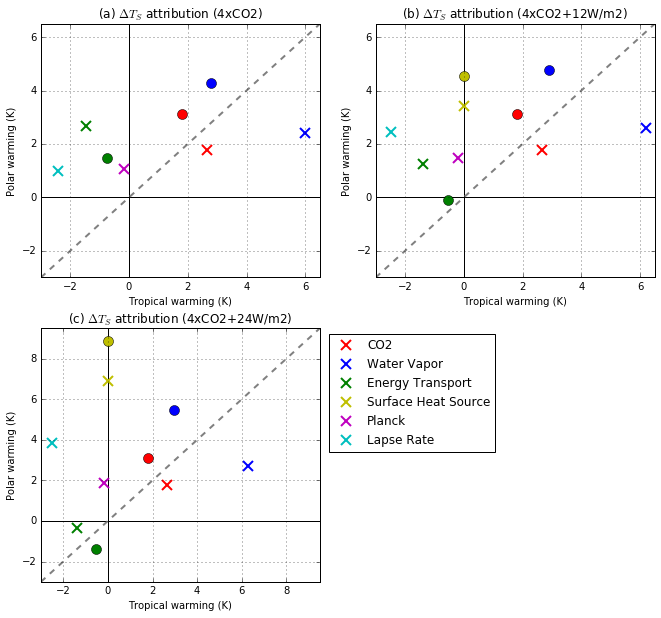

In [13]:
ms=10
mew=2
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 10)
plt.subplot(2,2,1)
plt.hlines(0, -3, 7,linewidth=1, color='k')
plt.vlines(0, -3, 7,linewidth=1, color='k')
plt.plot(F_CO2_trop,F_CO2_poles, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop,WVFB_CO2_poles, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop,MSE_CO2_poles, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(PFB_CO2_trop, PFB_CO2_poles, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop,LFB_CO2_poles, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
# plt.plot(forcing_SHS_trop,forcing_SHS_poles, 'x', color='r', ms=ms, mew=mew, label='SHS')
plt.plot(model_t_co2_co2.state['Ts'] - model_t.state['Ts'], model_co2_co2.state['Ts'] - model.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_co2_q_local.state['Ts'] + model_t_co2_q_remote_Ts - 2*model_t.state['Ts'], model_co2_q_remote_Ts + model_co2_q_local.state['Ts'] - 2*model.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_co2_trans.state['Ts'] - model_t.state['Ts'], model_co2_transQ.state['Ts'] + model_co2_transT.state['Ts'] - 2*model.state['Ts'], 'o', c='g',markersize=msize)
# plt.plot(0, model_HS12_surf.state['Ts'] - model.state['Ts'], 'o', c='r',markersize=msize)
plt.plot([-3, 6.5], [-3, 6.5], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,6.5])
plt.ylim([-3,6.5])
# lgd = plt.legend(bbox_to_anchor=(1.45, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.grid()
plt.title('(a) $\Delta T_S$ attribution (4xCO2)')
plt.xlabel('Tropical warming (K)')
plt.ylabel('Polar warming (K)')

plt.subplot(2,2,2)
plt.hlines(0, -3, 7,linewidth=1, color='k')
plt.vlines(0, -3, 7,linewidth=1, color='k')
plt.plot(F_CO2_trop_12,F_CO2_poles_12, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop_12,WVFB_CO2_poles_12, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop_12,MSE_CO2_poles_12, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(forcing_SHS_trop_12,forcing_SHS_poles_12, 'x', color='y', ms=ms, mew=mew, label='Surface Heat Source')
plt.plot(PFB_CO2_trop_12, PFB_CO2_poles_12, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop_12,LFB_CO2_poles_12, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
plt.plot(model_t_HS12_co2.state['Ts'] - model_t.state['Ts'], model_HS12_co2.state['Ts'] - model.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_HS12_q_local.state['Ts'] + model_t_HS12_q_remote_Ts - 2*model_t.state['Ts'], model_HS12_q_remote_Ts + model_HS12_q_local.state['Ts'] - 2*model.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_HS12_trans.state['Ts'] - model_t.state['Ts'], model_HS12_transQ.state['Ts'] + model_HS12_transT.state['Ts'] - 2*model.state['Ts'], 'o', c='g',markersize=msize)
plt.plot(0, model_HS12_surf.state['Ts'] - model.state['Ts'], 'o', c='y',markersize=msize)
plt.plot([-3, 6.5], [-3, 6.5], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,6.5])
plt.ylim([-3,6.5])
# lgd = plt.legend(bbox_to_anchor=(1.45, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.grid()
plt.title('(b) $\Delta T_S$ attribution (4xCO2+12W/m2)')
plt.xlabel('Tropical warming (K)')
plt.ylabel('Polar warming (K)')

plt.subplot(2,2,3)
plt.hlines(0, -3, 9.5,linewidth=1, color='k')
plt.vlines(0, -3, 9.5,linewidth=1, color='k')
plt.plot(F_CO2_trop_24,F_CO2_poles_24, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop_24,WVFB_CO2_poles_24, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop_24,MSE_CO2_poles_24, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(forcing_SHS_trop_24,forcing_SHS_poles_24, 'x', color='y', ms=ms, mew=mew, label='Surface Heat Source')
plt.plot(PFB_CO2_trop_24, PFB_CO2_poles_24, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop_24,LFB_CO2_poles_24, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
plt.plot(model_t_co2_co2.state['Ts'] - model_t.state['Ts'], model_co2_co2.state['Ts'] - model.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_HS24_q_local.state['Ts'] + model_t_HS24_q_remote_Ts - 2*model_t.state['Ts'], model_HS24_q_remote_Ts + model_HS24_q_local.state['Ts'] - 2*model.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_HS24_trans.state['Ts'] - model_t.state['Ts'], model_HS24_transQ.state['Ts'] + model_HS24_transT.state['Ts'] - 2*model.state['Ts'], 'o', c='g',markersize=msize)
plt.plot(0, model_HS24_surf.state['Ts'] - model.state['Ts'], 'o', c='y',markersize=msize)
plt.plot([-3, 9.5], [-3, 9.5], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,9.5])
plt.ylim([-3,9.5])
lgd = plt.legend(bbox_to_anchor=(1.65, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.grid()
plt.title('(c) $\Delta T_S$ attribution (4xCO2+24W/m2)')
plt.xlabel('Tropical warming (K)')
plt.ylabel('Polar warming (K)')
plt.savefig('fig4.eps', bbox_inches='tight')
plt.show()

# Supplementary figures

# Supplementary Figure 1 (Albedo)

/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type


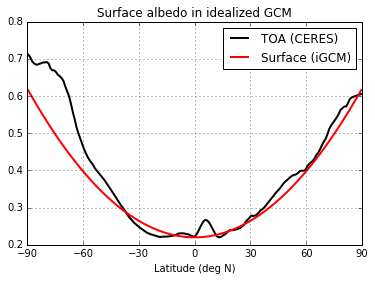

In [14]:
albedo_CERES_ = netCDF4.Dataset('../HenryMerlis19_SRM/CERES_albedo.nc')
lat_ = albedo_CERES_.variables['lat'][:]
sol_ = np.mean(np.mean(albedo_CERES_.variables['solar_clim'][:],0),1)
toasw_ = np.mean(np.mean(albedo_CERES_.variables['toa_sw_all_clim'][:],0),1)
plt.plot(lat_,toasw_/sol_,'k',linewidth=2, label='TOA (CERES)')

CERES_albedo_poly = 0.22 + 0.4*(lat_/90)**2
plt.plot(lat_,CERES_albedo_poly,'r',linewidth=2, label='Surface (iGCM)')

# albedo_value=0.22
# higher_albedo = 0.62
# albedo_exp = 2
# mima_albedo = albedo_value + (higher_albedo-albedo_value)*(lat_/90.)**albedo_exp
# plt.plot(lat_,mima_albedo,'b',linewidth=2, label='mima')

plt.legend(loc='best')
plt.title('Surface albedo in idealized GCM')
plt.xlabel('Latitude (deg N)')
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.legend(loc='best')
plt.grid()
plt.savefig('figS1.eps')
plt.show()

## Supplementary figure 2 (temperature tendencies from GCM prescribed in SCM)

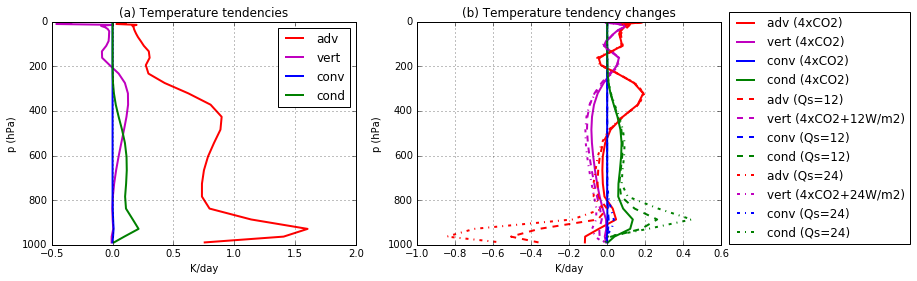

In [15]:
lat=80
iGCM_run=co2
dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_advection'][:],0),2)
dt_adv_ctl = plot_pole(dt_adv_ctl_,iGCM_run.lat_,lat)
dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)
dt_adv_inc = plot_pole(dt_adv_inc_,iGCM_run.lat_,lat)
dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_condensation'][:],0),2)
dt_cond_ctl = plot_pole(dt_cond_ctl_,iGCM_run.lat_,lat)
dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)
dt_cond_inc = plot_pole(dt_cond_inc_,iGCM_run.lat_,lat)
dt_conv_ctl_ = np.mean(np.mean(iGCM_run.s_lin.variables['dt_tg_convection'][:],0),2)
dt_conv_ctl = plot_pole(dt_conv_ctl_,iGCM_run.lat_,lat)
dt_conv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_convection'][:],0),2)
dt_conv_inc = plot_pole(dt_conv_inc_,iGCM_run.lat_,lat)

iGCM_run=co2_HS12
dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)
dt_adv_inc_HS12 = plot_pole(dt_adv_inc_,iGCM_run.lat_,lat)
dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)
dt_cond_inc_HS12 = plot_pole(dt_cond_inc_,iGCM_run.lat_,lat)
dt_conv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_convection'][:],0),2)
dt_conv_inc_HS12 = plot_pole(dt_conv_inc_,iGCM_run.lat_,lat)

iGCM_run=co2_HS24
dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2)
dt_adv_inc_HS24 = plot_pole(dt_adv_inc_,iGCM_run.lat_,lat)
dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2)
dt_cond_inc_HS24 = plot_pole(dt_cond_inc_,iGCM_run.lat_,lat)
dt_conv_inc_ = np.mean(np.mean(iGCM_run.s_lin_14xCO2.variables['dt_tg_convection'][:],0),2)
dt_conv_inc_HS24 = plot_pole(dt_conv_inc_,iGCM_run.lat_,lat)

from scipy.interpolate import interp1d
def mydiv_w(field):
    field_conv = np.zeros((co2.sig_.shape[0],field.shape[1]))
    for j in range(co2.lat_.shape[0]):
        funct = interp1d(co2.sig_,field[:,j],fill_value='extrapolate')
        field_conv[:,j]=np.diff(funct(co2.sig_stag))/np.diff(co2.sig_stag)
    return field_conv

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(3600*24*dt_adv_ctl,iGCM_run.sig_*1000,c='r',label='adv',linewidth=2)
plt.plot(3600*24*plot_pole(-co2.f_lin.variables['w_avg'][:]*mydiv_w(co2.temp_lin),iGCM_run.lat_,80),iGCM_run.sig_*1000,c='m',label='vert',linewidth=2)
plt.plot(3600*24*dt_conv_ctl,iGCM_run.sig_*1000,c='b',label='conv',linewidth=2)
plt.plot(3600*24*dt_cond_ctl,iGCM_run.sig_*1000,c='g',label='cond',linewidth=2)
plt.title('(a) Temperature tendencies')
plt.xlabel('K/day')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(3600*24*(dt_adv_inc-dt_adv_ctl),iGCM_run.sig_*1000,c='r',label='adv (4xCO2)',linewidth=2)
plt.plot(3600*24*plot_pole(-co2.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2.temp_lin_14xCO2)+
         co2.f_lin.variables['w_avg'][:]*mydiv_w(co2.temp_lin),iGCM_run.lat_,80),iGCM_run.sig_*1000,'m',
        label='vert (4xCO2)',linewidth=2)
plt.plot(3600*24*(dt_conv_inc-dt_conv_ctl),iGCM_run.sig_*1000,c='b',label='conv (4xCO2)',linewidth=2)
plt.plot(3600*24*(dt_cond_inc-dt_cond_ctl),iGCM_run.sig_*1000,c='g',label='cond (4xCO2)',linewidth=2)
plt.plot(3600*24*(dt_adv_inc_HS12-dt_adv_ctl),iGCM_run.sig_*1000,'r--',label='adv (Qs=12)',linewidth=2)
plt.plot(3600*24*plot_pole(-co2_HS12.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2_HS12.temp_lin_14xCO2)+
         co2_HS12.f_lin.variables['w_avg'][:]*mydiv_w(co2_HS12.temp_lin),iGCM_run.lat_,80),iGCM_run.sig_*1000,'m--',
        label='vert (4xCO2+12W/m2)',linewidth=2)
plt.plot(3600*24*(dt_conv_inc_HS12-dt_conv_ctl),iGCM_run.sig_*1000,'b--',label='conv (Qs=12)',linewidth=2)
plt.plot(3600*24*(dt_cond_inc_HS12-dt_cond_ctl),iGCM_run.sig_*1000,'g--',label='cond (Qs=12)',linewidth=2)
plt.plot(3600*24*(dt_adv_inc_HS24-dt_adv_ctl),iGCM_run.sig_*1000,'r-.',label='adv (Qs=24)',linewidth=2)
plt.plot(3600*24*plot_pole(-co2_HS24.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2_HS24.temp_lin_14xCO2)+
         co2_HS24.f_lin.variables['w_avg'][:]*mydiv_w(co2_HS24.temp_lin),iGCM_run.lat_,80),iGCM_run.sig_*1000,'m-.',
        label='vert (4xCO2+24W/m2)',linewidth=2)
plt.plot(3600*24*(dt_conv_inc_HS24-dt_conv_ctl),iGCM_run.sig_*1000,'b-.',label='conv (Qs=24)',linewidth=2)
plt.plot(3600*24*(dt_cond_inc_HS24-dt_cond_ctl),iGCM_run.sig_*1000,'g-.',label='cond (Qs=24)',linewidth=2)
plt.title('(b) Temperature tendency changes')
plt.xlabel('K/day')
plt.ylabel('p (hPa)')
lgd =plt.legend(bbox_to_anchor=(1.64, 1.07))
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS2.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Supplementary figure 3 (analog of figure 2 with latitude bounds set to 20 and 60).

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
198.999615372
82.6552716669
199.02764907
80.5192788813
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
399.999248033
87.0066756032
399.699656079
85.7047609478


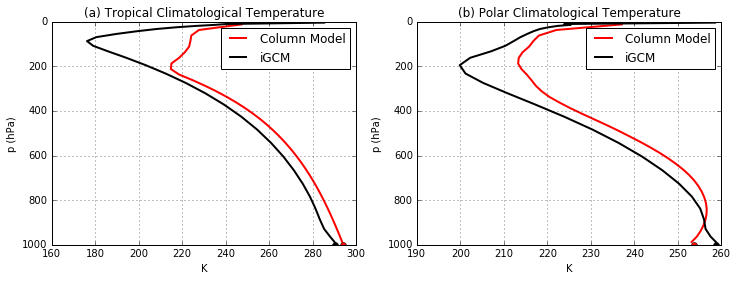

In [16]:
iGCM_run=co2
model_lat = run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=199, alb=0.45, transpT_ctl=True,transpQ_ctl=True, 
                        sh_ctl=True,lat=60)

TOA_SW_down = model_lat.SW_flux_down[0]
print(TOA_SW_down)
TOA_SW_up = model_lat.SW_flux_up[0]
print(TOA_SW_up)

swsfc_net = np.mean(np.mean(iGCM_run.s_lin.variables['swsfc'][:],0),1)
swtoa_up = np.mean(np.mean(iGCM_run.s_lin.variables['swup_toa'][:],0),1)
swtoa_dn = np.mean(np.mean(iGCM_run.s_lin.variables['swdn_toa'][:],0),1)

print(mean_lat(iGCM_run.lat_[iGCM_run.lat_>=60],swtoa_dn[iGCM_run.lat_>=60]))
print(mean_lat(iGCM_run.lat_[iGCM_run.lat_>=60],swtoa_up[iGCM_run.lat_>=60]))

model_t_lat = run_eq_column(iGCM_run=co2, co2_lev=3e-4, insol=400, alb=0.20, transp_ctl=True,sh_ctl=True,lat=20)

TOA_SW_down = model_t_lat.SW_flux_down[0]
print(TOA_SW_down)
TOA_SW_up = model_t_lat.SW_flux_up[0]
print(TOA_SW_up)

swsfc_net = np.mean(np.mean(iGCM_run.s_lin.variables['swsfc'][:],0),1)
swtoa_up = np.mean(np.mean(iGCM_run.s_lin.variables['swup_toa'][:],0),1)
swtoa_dn = np.mean(np.mean(iGCM_run.s_lin.variables['swdn_toa'][:],0),1)

masks = [iGCM_run.lat_>-30,iGCM_run.lat_<30]
mask = masks[0] & masks[1]
print(mean_lat(iGCM_run.lat_[mask],swtoa_dn[mask]))
print(mean_lat(iGCM_run.lat_[mask],swtoa_up[mask]))

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_lat.state['Tatm'],model_t_lat.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t_lat.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(plot_eq(iGCM_run.temp_lin,iGCM_run.lat_,30),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[mask],iGCM_run.sat_lin[mask]), 1000, 'ko',markersize=6)
plt.title('(a) Tropical Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_lat.state['Tatm'],model_lat.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_lat.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_pole(iGCM_run.temp_lin,60),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[iGCM_run.lat_>60],iGCM_run.sat_lin[iGCM_run.lat_>60]), 1000, 'ko',markersize=6)
plt.title('(b) Polar Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS3.eps', bbox_inches='tight')
plt.show()

## Supplementary figure 4 (relative humidity)

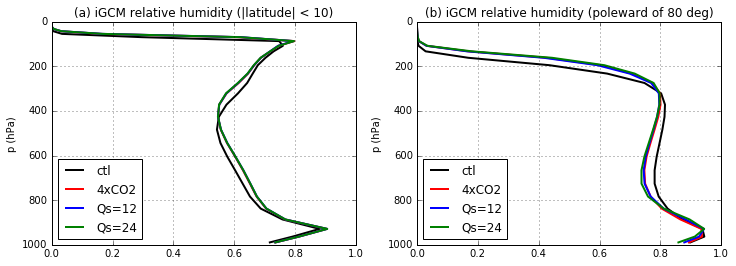

In [17]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(plot_eq(co2.f_lin.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'k', label='ctl',linewidth=2)
plt.plot(plot_eq(co2.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'r', label='4xCO2',linewidth=2)
plt.plot(plot_eq(co2_HS12.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'b', label='Qs=12',linewidth=2)
plt.plot(plot_eq(co2_HS24.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'g', label='Qs=24',linewidth=2)
plt.title('(a) iGCM relative humidity (|latitude| < 10)')
# plt.xlabel('K')
plt.ylabel('p (hPa)')
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(plot_pole(co2.f_lin.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'k', label='ctl',linewidth=2)
plt.plot(plot_pole(co2.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'r', label='4xCO2',linewidth=2)
plt.plot(plot_pole(co2_HS12.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'b', label='Qs=12',linewidth=2)
plt.plot(plot_pole(co2_HS24.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'g', label='Qs=24',linewidth=2)
plt.title('(b) iGCM relative humidity (poleward of 80 deg)')
# plt.xlabel('K')
plt.ylabel('p (hPa)')
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS4.eps', bbox_inches='tight')
plt.show()

## Supplementary figures 5-8 (checking fixed RH SCM)

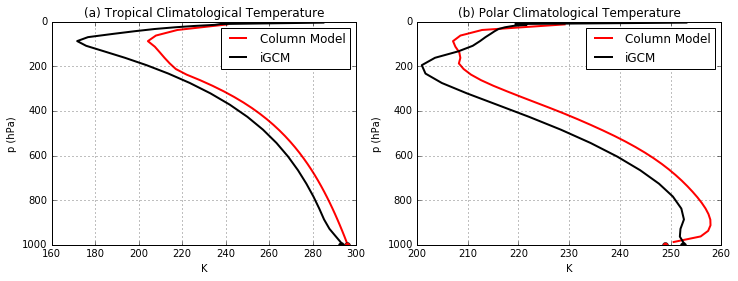

In [18]:
lat=10
masks = [iGCM_run.lat_>-lat,iGCM_run.lat_<lat]
mask = masks[0] & masks[1]

iGCM_run = co2
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl_RH.state['Tatm'],model_t_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t_ctl_RH.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(plot_eq(co2.temp_lin,co2.lat_,10),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[mask],iGCM_run.sat_lin[mask]), 1000, 'ko',markersize=6)
plt.title('(a) Tropical Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl_RH.state['Tatm'],model_p_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_p_ctl_RH.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_pole(iGCM_run.temp_lin,80),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[iGCM_run.lat_>80],iGCM_run.sat_lin[iGCM_run.lat_>80]), 1000, 'ko',markersize=6)
plt.title('(b) Polar Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS5.eps', bbox_inches='tight')
plt.show()

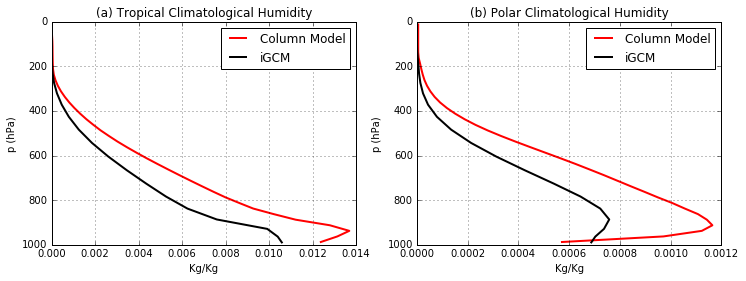

In [19]:
iGCM_run = co2
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl_RH.q,model_t_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(iGCM_run.plot_eq(iGCM_run.q_lin),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(a) Tropical Climatological Humidity')
plt.xlabel('Kg/Kg')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl_RH.q,model_p_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(iGCM_run.plot_pole(iGCM_run.q_lin,80),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(b) Polar Climatological Humidity')
plt.xlabel('Kg/Kg')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS6.eps', bbox_inches='tight')
plt.show()

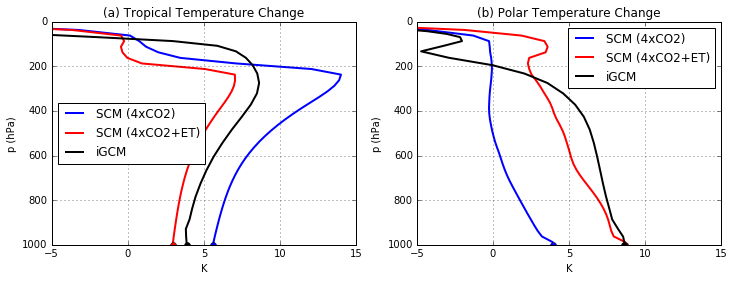

In [20]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_co2_RH.Tatm-model_t_ctl_RH.Tatm,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_t_co2_RH.Ts-model_t_ctl_RH.Ts, 1000, 'bo',markersize=6)
plt.plot(model_t_full_RH.Tatm-model_t_ctl_RH.Tatm,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(model_t_full_RH.Ts-model_t_ctl_RH.Ts, 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_eq(iGCM_run.temp_lin_diff),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[mask],iGCM_run.sat_lin_diff[mask]), 1000, 'ko',markersize=6)
plt.title('(a) Tropical Temperature Change')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_co2_RH.Tatm-model_p_ctl_RH.Tatm,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_p_co2_RH.Ts-model_p_ctl_RH.Ts, 1000, 'bo',markersize=6)
plt.plot(model_p_full_RH.Tatm-model_p_ctl_RH.Tatm,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(model_p_full_RH.Ts-model_p_ctl_RH.Ts, 1000, 'ro',markersize=6)
plt.plot(iGCM_run.plot_pole(iGCM_run.temp_lin_diff,80),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(iGCM_run.lat_[iGCM_run.lat_>80],iGCM_run.sat_lin_diff[iGCM_run.lat_>80]), 1000, 'ko',markersize=6)
plt.title('(b) Polar Temperature Change')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS7.eps', bbox_inches='tight')
plt.show()

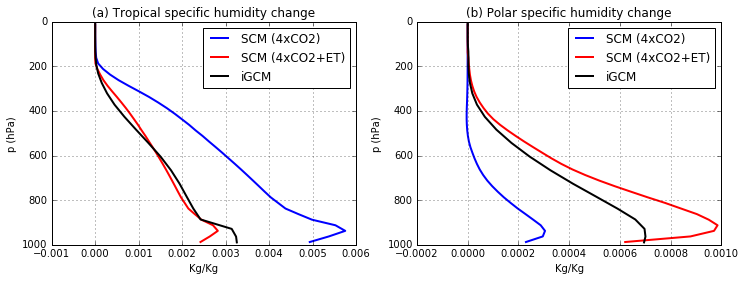

In [21]:
iGCM_run = co2
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_co2_RH.q-model_t_ctl_RH.q,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_t_full_RH.q-model_t_ctl_RH.q,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(iGCM_run.plot_eq(iGCM_run.q_lin_diff),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(a) Tropical specific humidity change')
plt.xlabel('Kg/Kg')
plt.ylabel('p (hPa)')
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_co2_RH.q-model_p_ctl_RH.q,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_p_full_RH.q-model_p_ctl_RH.q,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(iGCM_run.plot_pole(iGCM_run.q_lin_diff,80),iGCM_run.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(b) Polar specific humidity change')
plt.xlabel('Kg/Kg')
plt.ylabel('p (hPa)')
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS8.eps', bbox_inches='tight')
plt.show()